In [1]:
import os
import re

import concurrent.futures

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

tf.get_logger().setLevel('INFO')

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [4]:
@tf.function
def tf_data_to_dense(voxel_data, voxel_map_shape=(128, 128, 128)):
    dense_voxel_maps = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    for voxel_coords_tensor in voxel_data:
        value_map = tf.ones(tf.shape(voxel_coords_tensor)[:-1], dtype=tf.float32)

        voxel_map = tf.zeros(voxel_map_shape, dtype=tf.float32)
        voxel_map = tf.tensor_scatter_nd_add(voxel_map, voxel_coords_tensor, value_map)

        dense_voxel_maps = dense_voxel_maps.write(dense_voxel_maps.size(), voxel_map)
        
    return tf.expand_dims(dense_voxel_maps.stack(), axis=-1)

In [5]:
class DataGenerator:
    def __init__(self, dataset_dir_pth, each_chair_parts_count_pth, objs_count=None, batch_size=4):
        self.dataset_dir_pth = dataset_dir_pth

        self.each_chair_parts_count = np.load(each_chair_parts_count_pth)[:objs_count]
        self.num_objts = len(self.each_chair_parts_count)

        self.data_names = np.array(sorted_alphanumeric(os.listdir(self.dataset_dir_pth)), dtype=str)[:self._get_total_parts_size()]
        self.num_parts = len(self.data_names)

        self.batch_szie = batch_size

        self.part_voxels_coords = self._load_voxel_data()

    def _get_total_parts_size(self):
        count = 0

        if self.num_objts == None:
            return None

        for i in range(self.num_objts):
            count += self.each_chair_parts_count[i]

        return count

    def _load_voxel_data(self):
        print('Trying to load {} objects with total {} parts.'.format(self.num_objts, self.num_parts))
        
        def load_data(data_pth):
            return np.load(data_pth)

        with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            data_paths = [os.path.join(self.dataset_dir_pth, data_name) for data_name in self.data_names]
            part_voxels_coords = list(tqdm(executor.map(load_data, data_paths), total=len(data_paths)))

        return part_voxels_coords
    
    def get_tf_dataset(self):
        print('Generating TF dataset.')

        part_indices = tf.range(self.num_parts)
        
        part_voxels_coords = tf.RaggedTensor.from_row_lengths(tf.concat(self.part_voxels_coords, axis=0), row_lengths=[a.shape[0] for a in self.part_voxels_coords])
        
        dataset = tf.data.Dataset.from_tensor_slices((part_indices, part_voxels_coords)).batch(self.batch_szie, drop_remainder=True)
        return dataset

    def reset_index(self):
        self.curr_index = 0

In [6]:
EACH_CHAIR_PARTS_COUNT_PTH = ".\\dataset\\each_chair_parts_count.npy"
DATASET_DIR_PTH = ".\\dataset\\chair_voxel_data"

LOAD_OBJS_COUNT = None
VOXEL_MAP_SHAPE = (128, 128, 128)

BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

In [7]:
data_generator = DataGenerator(dataset_dir_pth=DATASET_DIR_PTH,
                               each_chair_parts_count_pth=EACH_CHAIR_PARTS_COUNT_PTH,
                               objs_count=LOAD_OBJS_COUNT,
                               batch_size=GLOBAL_BATCH_SIZE)

dataset = data_generator.get_tf_dataset()

dataset_size = tf.data.experimental.cardinality(dataset).numpy()

dist_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)

Trying to load 8176 objects with total 162779 parts.


100%|██████████| 162779/162779 [00:50<00:00, 3227.43it/s] 


In [8]:
class PartNetwork:
    def __init__(self, hparam):
        self.latent_code_dim = hparam['model_latent_code_dim']

        self.fc_channels = hparam['model_fc_channels']

        self.conv_size = hparam['model_conv_size']

        self.num_latent_codes_parts = hparam['model_num_latent_codes_parts']

        self.learning_rate_network = hparam['model_learning_rate_network']
        self.learning_rate_codes = hparam['model_learning_rate_codes']

        self.model_voxel_map_shape = hparam['model_voxel_map_shape']

        self.checkpoint_dir = hparam['model_checkpoint_dir']
        
        self.trained_epoch = tf.Variable(0)

        self._init_model()
        self._init_optimizer()
        self._init_losser()
        self._init_checkpoint()

    def _init_model(self):
        self.part_generator = self._get_generator()

        init_latent_code_parts = tf.random.normal((self.num_latent_codes_parts, self.latent_code_dim))
        self.latent_code_vars_parts = tf.Variable(init_latent_code_parts, trainable=True)

        self.part_generator_trainable_variables = self.part_generator.trainable_variables

    def _get_generator(self):
        with mirrored_strategy.scope():
            
            with tf.name_scope('Network/'):

                latent_code = tf.keras.layers.Input(shape=(self.latent_code_dim,))

                with tf.name_scope('FC_layers'):

                    fc0 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(latent_code)

                    fc1 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(fc0)

                    fc2 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(fc1)

                    fc2_as_volume = tf.keras.layers.Reshape((1, 1, 1, self.fc_channels))(fc2)

                with tf.name_scope('GLO_VoxelDecoder'):

                    decoder_1 = self._conv_t_block_3d(fc2_as_volume, num_filters=32, size=self.conv_size, strides=2)

                    decoder_2 = self._conv_t_block_3d(decoder_1, num_filters=32, size=self.conv_size, strides=2)

                    decoder_3 = self._conv_t_block_3d(decoder_2, num_filters=32, size=self.conv_size, strides=2)

                    decoder_4 = self._conv_t_block_3d(decoder_3, num_filters=16, size=self.conv_size, strides=2)

                    decoder_5 = self._conv_t_block_3d(decoder_4, num_filters=8, size=self.conv_size, strides=2)

                    decoder_6 = self._conv_t_block_3d(decoder_5, num_filters=4, size=self.conv_size, strides=2)

                    volume_out = self._conv_t_block_3d(decoder_6, num_filters=1, size=self.conv_size, strides=2, output_mode=True)

            model = tf.keras.Model(inputs=[latent_code], outputs=[volume_out])

        return model

    def _conv_t_block_3d(self, tensor, num_filters, size, strides, alpha_lrelu=0.2, output_mode=False):
        conv_3D_transpose = tf.keras.layers.Conv3DTranspose(
            filters=num_filters,
            kernel_size=size,
            strides=strides,
            padding='same',
            kernel_initializer=tf.keras.initializers.glorot_normal(),
            use_bias=False
        )

        tensor = conv_3D_transpose(tensor)

        if output_mode:
            return tensor

        tensor = tf.keras.layers.BatchNormalization()(tensor)

        tensor = tf.keras.layers.LeakyReLU(alpha=alpha_lrelu)(tensor)

        return tensor

    def _init_optimizer(self):
        with mirrored_strategy.scope():
            self.optimizer_part_generator = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_network)
            self.optimizer_latent_for_parts = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_codes)

    def _init_losser(self):
        self.losser_bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    def _init_checkpoint(self):
        self.checkpoint = tf.train.Checkpoint(
            part_generator=self.part_generator,
            latent_code_vars_parts=self.latent_code_vars_parts,
            optimizer_part_generator=self.optimizer_part_generator,
            optimizer_latent_for_parts=self.optimizer_latent_for_parts,
            trained_epoch=self.trained_epoch
        )

        self.manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                  directory=self.checkpoint_dir,
                                                  max_to_keep=1)

        self._load_checkpoint()

    def _load_checkpoint(self):
        latest_checkpoint = self.manager.latest_checkpoint

        if latest_checkpoint is not None:
            print('Checkpoint {} restored'.format(latest_checkpoint))
        else:
            print('No checkpoint was restored.')

        self.checkpoint.restore(latest_checkpoint).expect_partial()

    @tf.function
    def train_step_parts(self, latent_code_vars, true_voxels_part):
        with tf.GradientTape() as tape:
            pred_logits_voxels = self.part_generator(latent_code_vars)

            pred_voxels_part = tf.sigmoid(pred_logits_voxels)

            loss = self.losser_bce(true_voxels_part, pred_voxels_part)
            loss = tf.nn.compute_average_loss(loss)

            model_losses = self.part_generator.losses
            if model_losses:
                loss = loss + tf.nn.scale_regularization_loss(tf.add_n(model_losses))

        network_vars = self.part_generator_trainable_variables
        gradients = tape.gradient(loss, network_vars + [latent_code_vars])

        self.optimizer_part_generator.apply_gradients(zip(gradients[:len(network_vars)], network_vars))
        self.optimizer_latent_for_parts.apply_gradients(zip(gradients[len(network_vars):], [latent_code_vars]))

        return loss
    
    @tf.function
    def distributed_train_step(self, train_func, args):
        per_replica_losses = mirrored_strategy.run(train_func, args=args)
        return mirrored_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    
    def get_latent_code_vars_by_indices(self, latent_code_vars, latent_code_indices):
        return tf.Variable(tf.gather(latent_code_vars, latent_code_indices), trainable=True)
    
    def update_latent_code_vars(self, indices, latent_code_vars):
        self.latent_code_vars_parts.assign(tf.tensor_scatter_nd_update(self.latent_code_vars_parts, tf.expand_dims(indices, 1), latent_code_vars))

    def save_models(self):
        self.manager.save(checkpoint_number=self.trained_epoch.numpy())

In [9]:
model_hparam = {
    'model_latent_code_dim': 256,
    'model_fc_channels': 512,
    'model_conv_size': 4,
    'model_num_latent_codes_parts': data_generator.num_parts,
    'model_learning_rate_network': 5e-4,
    'model_learning_rate_codes': 1e-3,
    'model_voxel_map_shape': VOXEL_MAP_SHAPE,
    'model_checkpoint_dir': './ckpt_dist'
}

part_network = PartNetwork(model_hparam)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
max_no_improvement = 3
min_loss_change = 10

prev_avg_loss = None
prev_change = None

no_improvement_count = 0

while True:
    total_loss = []

    part_network.trained_epoch.assign(part_network.trained_epoch+1)

    pbar = tqdm(dist_dataset, desc='[Epoch {}]'.format(part_network.trained_epoch.numpy()), total=dataset_size)

    for latent_code_indices, true_voxels_coords in pbar:
        true_voxels_maps = mirrored_strategy.run(tf_data_to_dense, args=(true_voxels_coords,))
        latent_code_vars = mirrored_strategy.run(part_network.get_latent_code_vars_by_indices, args=(part_network.latent_code_vars_parts, latent_code_indices,))

        loss = part_network.distributed_train_step(part_network.train_step_parts, (latent_code_vars, true_voxels_maps))

        total_loss.append(loss)

        mirrored_strategy.run(part_network.update_latent_code_vars, args=(latent_code_indices, latent_code_vars,))

        avg_loss = sum(total_loss) / len(total_loss)

        pbar.set_postfix({'Avg Loss': '{:.9f}'.format(avg_loss)})

    if prev_avg_loss is not None:
        curr_change = prev_avg_loss - avg_loss

        if curr_change < min_loss_change:
            no_improvement_count += 1
            print('No improvement count increased to {}.'.format(no_improvement_count))
        else:
            no_improvement_count = 0
            print('Reset No improvement count.')

    prev_avg_loss = avg_loss

    if no_improvement_count >= max_no_improvement:
        print('Early stopping as loss change has been less than {} for {} consecutive epochs.'.format(min_loss_change, max_no_improvement))
        break

    part_network.save_models()

In [10]:
def rotate_obj_along_axis(voxel_coordinates, rotation_angle, axis, voxel_map_shape=(128, 128, 128)):
    theta = np.radians(rotation_angle)
    
    if axis == 'x':
        rot_matrix = np.array([[1, 0, 0],
                                [0, np.cos(theta), -np.sin(theta)],
                                [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        rot_matrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                                [0, 1, 0],
                                [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    else:
        raise ValueError("Invalid axis. Must be 'x', 'y', or 'z'.")
        
    center = np.array(voxel_map_shape) / 2
    centered_coordinates = voxel_coordinates - center
        
    rotated_coords = np.dot(centered_coordinates, rot_matrix.T)
    rotated_coords += center
    
    rotated_coords = np.round(rotated_coords).astype(int)
    valid_indices = np.all((rotated_coords >= 0) & (rotated_coords < np.array(voxel_map_shape)), axis=1)
    
    rotated_coords = rotated_coords[valid_indices]

    return rotated_coords

In [11]:
def data_to_dense(voxel_data, voxel_map_shape=(128, 128, 128), value=1.0):
    dense_objs_voxel_data = []
    
    for obj_voxel_coordinates in voxel_data:
        voxel_map = np.zeros(voxel_map_shape, dtype=np.float32)
        voxel_map[tuple(obj_voxel_coordinates.T)] = value
        dense_objs_voxel_data.append(voxel_map)
        
    return dense_objs_voxel_data

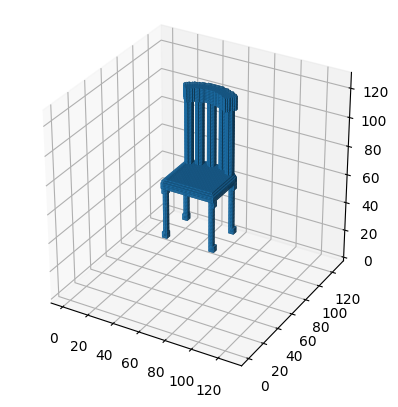

In [12]:
test_target_obj = 0

base_index = 0

for i in range(test_target_obj):
    base_index += data_generator.each_chair_parts_count[i]

true_voxels = np.zeros(shape=(VOXEL_MAP_SHAPE), dtype=np.int32)

for i in range(base_index, base_index+data_generator.each_chair_parts_count[test_target_obj]):
    true_voxels_coords = np.load(os.path.join(DATASET_DIR_PTH, str(i)+'.npy'))
    
    for x, y, z in true_voxels_coords:
        true_voxels[x, y, z] = 1

true_voxels_coords = np.where(true_voxels == 1)

x, y, z = true_voxels_coords
true_voxels_coords = np.expand_dims(x, axis=0).T
true_voxels_coords = np.concatenate((true_voxels_coords, np.expand_dims(y, axis=0).T), axis=1)
true_voxels_coords = np.concatenate((true_voxels_coords, np.expand_dims(z, axis=0).T), axis=1)

true_voxel_rotated_coords = rotate_obj_along_axis(true_voxels_coords, rotation_angle=180, axis='y')
true_voxel_rotated = data_to_dense([true_voxel_rotated_coords])[0]

true_voxel_rotated_plot = np.moveaxis(true_voxel_rotated, 1, -1)

ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.voxels(true_voxel_rotated_plot)

plt.show()

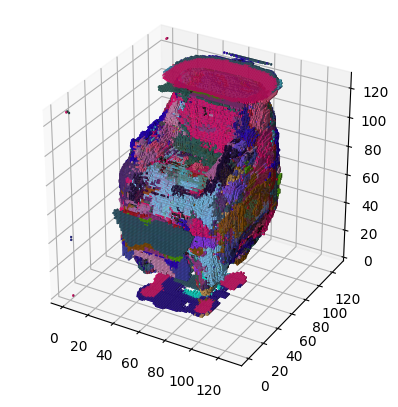

In [21]:
import random

test_target_obj = 0

base_index = 0

for i in range(test_target_obj):
    base_index += data_generator.each_chair_parts_count[i]

latent_code_indices = np.arange(base_index, base_index+data_generator.each_chair_parts_count[test_target_obj])
latent_codes = tf.gather(part_network.latent_code_vars_parts, latent_code_indices)

pred_logits_voxels = part_network.part_generator(latent_codes)
pred_voxels = tf.sigmoid(pred_logits_voxels)
pred_voxels = tf.cast(tf.math.greater_equal(pred_voxels, 0.3), tf.float32).numpy()
pred_voxels = pred_voxels.reshape((pred_voxels.shape[:4]))

voxels = np.zeros(shape=VOXEL_MAP_SHAPE, dtype=np.int32)
colors = np.zeros(shape=(*VOXEL_MAP_SHAPE, 3), dtype=np.float32)

for part in pred_voxels:
    pred_voxel_coords = np.where(part == True)
    
    x, y, z = pred_voxel_coords
    pred_voxel_coords = np.expand_dims(x, axis=0).T
    pred_voxel_coords = np.concatenate((pred_voxel_coords, np.expand_dims(y, axis=0).T), axis=1)
    pred_voxel_coords = np.concatenate((pred_voxel_coords, np.expand_dims(z, axis=0).T), axis=1)
    
    color = np.array([random.random() for _ in range(3)], dtype=np.float32)
    
    for coordinates in rotate_obj_along_axis(pred_voxel_coords, rotation_angle=180, axis='y'):
        x, y, z = coordinates
        voxels[x, y, z] = 1
        colors[x, y, z] = color

voxels = np.moveaxis(voxels, 1, -1)
colors = np.moveaxis(colors, 1, -2)

ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.voxels(voxels, facecolors=colors)

plt.show()